In [205]:
#Dependencies
import numpy as np
import pylab as pl
import tensorflow as tf
import matplotlib.pyplot as plt

import utils.plotutils as plu
import utils.imreadin as imr

%matplotlib inline

In [214]:
#Model Parameters

#entwork params
compression = 5
patchsize = 16

#training params
batchsize = 50
iterations = 11000
epochs = 2

#noise
noisexsigma = 0 #1e-4
noisersigma = 0 #1e-4

minact = 0.1 #5e-1
minslo = 0.1 #1e-1
#bslfr = 1e-1

learning_rate = 0.0001

In [215]:
#Load in images if we haven't yet.

def loadimages(psz):
    print("Loading Van Hateren Natural Image Database...")
    vhimgs = imr.vanHateren(
        img_dir='../vanHaterenNaturalImages/VanHaterenNaturalImagesCurated.h5',
        normalize = True,
        patch_edge_size=psz
        )
    print("Done Loading!")    
    np.random.shuffle(vhimgs.images)
    print("Done Shuffling!")
    return(vhimgs, psz)

try:
    vhims
except NameError:
    vhims, loadedpatchsize = loadimages(patchsize)
    
if(patchsize != loadedpatchsize):
    vhims, loadedpatchsize = loadimages(patchsize)
       
print("Images Loaded.")

#params of images
imxlen = len(vhims.images[0,0,:])
imylen = len(vhims.images[0,:,0])
nimages = len(vhims.images[:,0,0])

nimstrained = batchsize * iterations

if(nimstrained > nimages):
    print('ERROR! Trying to train',nimstrained,'images, but we only have',nimages,'images!')
else:
    print('Training',nimstrained,'out of',nimages,'total image patches.')

Images Loaded.
Training 550000 out of 4685824 total image patches.


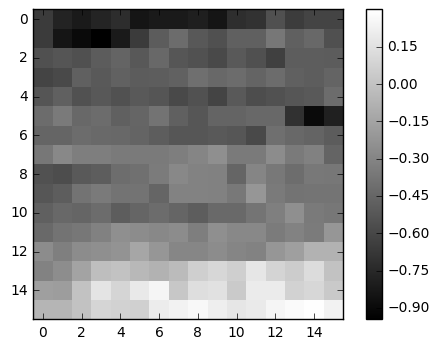

In [216]:
#show an example image
plt.imshow(vhims.images[1],cmap='gray',interpolation='none')
plt.colorbar()

In [217]:
nneurons = np.int(imxlen*imylen/compression)
print('Compressing by',compression,'for a total of',nneurons,'neurons')

#input image
x = tf.placeholder(tf.float32, shape=(batchsize, imxlen*imylen),name='input_image')
#output image
#xp = tf.placeholder(tf.float32, shape=(batchsize,imxlen*imylen),name='output_image')

#noise
nxc = noisexsigma**2
nrc = noisersigma**2
nx = tf.constant(nxc,dtype=tf.float32,name='input_noise')
nr = tf.constant(nrc,dtype=tf.float32,name='internal_noise')

#weights
win = tf.Variable(tf.random_normal([imxlen*imylen,nneurons],dtype=tf.float32,stddev=0.01),name='weights_in')
#wout = tf.placeholder(tf.float32, shape=np.shape(win),name='weights_out')
#bias
bias = tf.Variable(tf.random_normal([nneurons],dtype=tf.float32,stddev=0.01),name='bias')

#calculate inner layer
y = tf.nn.tanh(tf.add(tf.matmul(tf.add(x,nx),win),bias))
#calculate ouer layer
xp = tf.nn.sigmoid(tf.matmul(y,tf.transpose(win)))
#calculate cost
cost = tf.sqrt(tf.reduce_mean(tf.square(x-xp)))

train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Compressing by 5 for a total of 51 neurons


In [218]:
#run it!
#sess = tf.Session
with tf.Session() as sess:
    #initialize vars
    init = tf.global_variables_initializer()
    sess.run(init)
    
    #save evolution of system over training
    cost_evolution = []
    y_evolution = []
    
    hist = {}
    
    #train over niterations
    nits = iterations #full run
    
    print('Training {} iterations in {} epochs...'.format(nits, epochs))
    for epoch in range(epochs):
        print('\nEpoch {}: '.format(epoch+1))
        np.random.shuffle(vhims.images)
        for ii in range(nits):
            if(ii%(int((nits)/10))==0):
                print(str(ii)+', ',end="")
            image = np.reshape(vhims.images[ii*batchsize:(1+ii)*batchsize,:,:],(batchsize,imxlen*imylen)).astype(np.float32)
            #noise_input = np.random.normal(0,noisexsigma,[patchsize**2,batchsize]).astype(np.float32)*0.
            #noise_response = np.random.normal(0,noisersigma,[nneurons,batchsize]).astype(np.float32)*0.
            hist[0] = image
            sess.run(train_step, feed_dict={x:image})

            #save evolution of params
            objcost = sess.run(cost, feed_dict={x:image})
            cost_evolution.append(objcost)
            yr = sess.run(y, feed_dict={x:image})
            y_evolution.append(np.mean(yr))
        

    weights = sess.run(win, feed_dict={x:image})
    print('\nDone!')

Training 11000 iterations in 2 epochs...

Epoch 1: 
0, 1100, 2200, 3300, 4400, 5500, 6600, 7700, 8800, 9900, 
Epoch 2: 
0, 1100, 2200, 3300, 4400, 5500, 6600, 7700, 8800, 9900, 
Done!


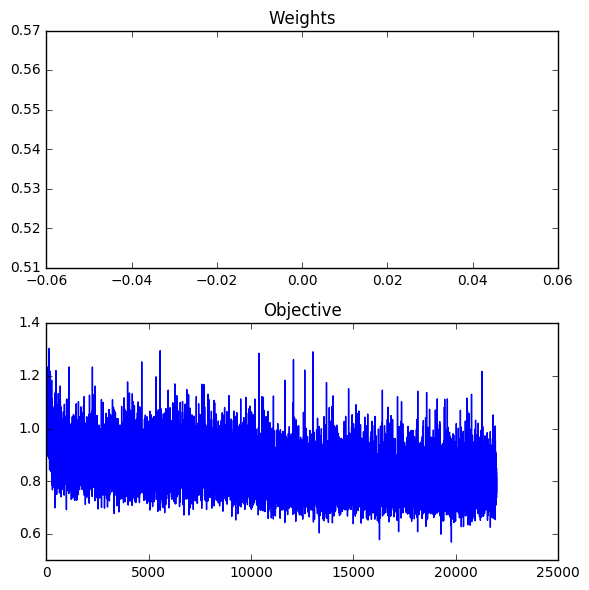

In [219]:
plt.figure(figsize=(6,6))

plt.subplot(2,1,1,title='Weights')
plt.plot(np.mean(y_evolution))

plt.subplot(2,1,2,title='Objective')
plt.plot(cost_evolution)

plt.tight_layout()

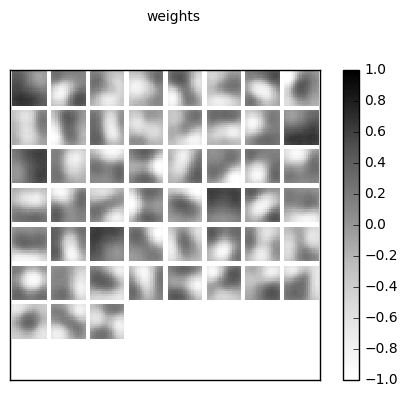

In [220]:
wr = np.rollaxis(np.reshape(weights,(imxlen,imylen,nneurons)),2)
plu.display_data_tiled(wr, normalize=False, title="weights", prev_fig=None)

In [221]:
def plotonoff(allws):
    allws = weights
    #get off center
    offws = np.mean(allws,axis=0)<0
    offws = allws[:,offws]
    #get on center
    onws = np.mean(allws,axis=0)>0
    onws = allws[:,onws]
    
    #plot
    plt.figure(figsize=(6,6))

    plt.subplot(1,2,1,title='On')
    plt.plot(np.mean(y_evolution))

    plt.subplot(1,2,2,title='Off')
    plt.plot(cost_evolution)

    plt.tight_layout()
    

In [203]:
np.mean(weights,axis=0)

array([-0.17381918, -0.08887458,  0.83287466, -0.12312812, -0.18025687,
       -0.08791813, -0.09907462, -0.21529029, -0.14281061, -0.07056693,
       -0.1334132 , -0.1493433 , -0.09035699, -0.08250953, -0.08298989,
       -0.08357472, -0.20591418, -0.16629796, -0.1305754 , -0.09025027,
       -0.15577975, -0.14222927, -0.08841002, -0.08093958, -0.18183233,
       -0.11643602, -0.18537009, -0.1404475 , -0.29638308, -0.08266442,
       -0.11714541,  0.63962048, -0.10721667, -0.08638205, -0.12979536,
       -0.26416919,  0.70526409, -0.27593103, -0.1268785 , -0.09873997,
       -0.09202183, -0.36493307, -0.19115858,  0.49026695, -0.13985017,
       -0.10798348, -0.0878384 , -0.27777073, -0.09065042, -0.17777097,
       -0.09203836], dtype=float32)

In [204]:
allws = weights

offws = np.mean(allws,axis=0)<0
offws = allws[:,offws]
print(offws)

[[ 0.15918297 -0.13268326  0.20162711 ..., -0.46891961  0.29285383
   0.01215614]
 [ 0.18822984 -0.06401557  0.34406587 ..., -0.24266927  0.24536337
   0.03040228]
 [ 0.18519093  0.05887163  0.48055387 ...,  0.06310794  0.0658572
   0.05557822]
 ..., 
 [-0.61638093 -0.14081953  0.38488859 ...,  0.30712813  0.2293011
   0.12559424]
 [-0.68645006 -0.09540095  0.31275421 ...,  0.24879402  0.24984153
   0.09932891]
 [-0.66043001 -0.05629204  0.18454622 ...,  0.16627343  0.20391868
   0.08103704]]
